# EU Proceedings - Danish

In [1]:
import glob
import regex
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
import h5py
import pickle 
from keras.models import load_model
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [2]:
import komma_dev.eu
from komma_dev.vocabulary import build_vocabulary
from komma_dev.parsing import StringParser
import komma_dev.metrics as metrics

In [3]:
eu_data_raw = komma_dev.eu.load('da')

loading: europarl-v7.da-en.da


We remove leading and trailing whitespace. When running on real user input this should be done separately and the amount and kind of removed whitespace should be stored and eventually added back onto the string.

In [4]:
eu_data_raw = [line.strip() for line in eu_data_raw]

We now parse each string using our StringParser class. This may take a while.

In [5]:
parser = StringParser()
eu_data = [parser.parse(line) for line in eu_data_raw]

## Split
The very first thing we need to do after having loaded the data is to create a train/dev split. We will eventually build a vocabulary, and it's important that we build this on the training data only.

In [6]:
eu_data_train, eu_data_dev = train_test_split(eu_data, test_size=0.01, random_state=42)

In [7]:
len(eu_data_train)

1949112

In [8]:
len(eu_data_dev)

19688

# Vocabulary
We can now build the vocabulary on the training data.

In [9]:
vocab, _ = build_vocabulary(eu_data_train, 10000)

In [10]:
len(vocab)

10000

In [11]:
MAX_CHUNKS = 50

def embed_sentence(sentence, vocabulary):
    embedded = [0] * MAX_CHUNKS
    for index, chunk in enumerate(sentence.chunks[:MAX_CHUNKS]):
        word = chunk.clean_name
        if word in vocabulary:
            word_id = vocabulary[word]
            embedded[index] = word_id
        else:
            # TODO: don't encode unknown as zero (probably use max(IDs) + 1)
            embedded[index] = len(vocab)+1
    return embedded

def pre_process(sentences, vocabulary):
    X = []
    Y = []
    for sentence in sentences:
        # TODO: Remove punctuation except comma?
        # sentence = remove_punctuation(sentence)
        y = sentence.commas[:MAX_CHUNKS] + ([0] * (MAX_CHUNKS-len(sentence.commas)))
        y = np.array(y)[np.newaxis]
        embedded_sentence = embed_sentence(sentence, vocabulary)
        X.append(embedded_sentence)
        Y.append(y)
    return X, Y

In [12]:
X_train, Y_train = pre_process(eu_data_train, vocab)

In [13]:
print(len(X_train))
print(len(Y_train))

1949112
1949112


In [14]:
X_dev, Y_dev = pre_process(eu_data_dev, vocab)

In [15]:
print(len(X_dev))
print(len(Y_dev))

19688
19688


In [16]:
# TODO: This only called to get NP arrays, so maybe make sure the X and Y are already NP arrays.
X_train = sequence.pad_sequences(X_train, maxlen=MAX_CHUNKS)
Y_train = np.concatenate(Y_train, axis=0)

X_dev = sequence.pad_sequences(X_dev, maxlen=MAX_CHUNKS)
Y_dev = np.concatenate(Y_dev, axis=0)

In [17]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_dev shape:', X_dev.shape)
print('Y_dev shape:', Y_dev.shape)

X_train shape: (1949112, 50)
Y_train shape: (1949112, 50)
X_dev shape: (19688, 50)
Y_dev shape: (19688, 50)


# Network

In [18]:
model = Sequential()
model.add(Embedding(len(vocab) + 2, 128, input_length=MAX_CHUNKS))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50))
model.add(Dense(MAX_CHUNKS))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           1280256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total para

# Train

In [20]:
METRIC_CALLBACK = metrics.callback()
HISTORY = model.fit(X_train, Y_train,
          batch_size=8,
          epochs=1,
          verbose=1,
          validation_data=(X_dev, Y_dev),
          callbacks=[METRIC_CALLBACK])
print('')
print('Sentence accuracy: {0:0.2f}, PR AUC: {1:0.2f}'.format(METRIC_CALLBACK.sentence_accuracy[-1],
                                                                METRIC_CALLBACK.pr_auc[-1]))
print('Loss: {0:0.4f} Val loss; {1:0.4f}'.format(HISTORY.history['loss'][-1],
                                                     HISTORY.history['val_loss'][-1]))

Train on 1949112 samples, validate on 19688 samples
Epoch 1/1
1949112/1949112 [==============================] - 11845s - loss: 0.0478 - acc: 0.9857 - val_loss: 0.0336 - val_acc: 0.9903

Sentence accuracy: 0.70, PR AUC: 0.67
Loss: 0.0478 Val loss; 0.0336


In [ ]:
#model.save('model.h5')

# Evaluate

In [21]:
Y_hat = model.predict_proba(X_dev)

19552/19688 [============================>.] - ETA: 0s

## Getting ROC and PR Curves

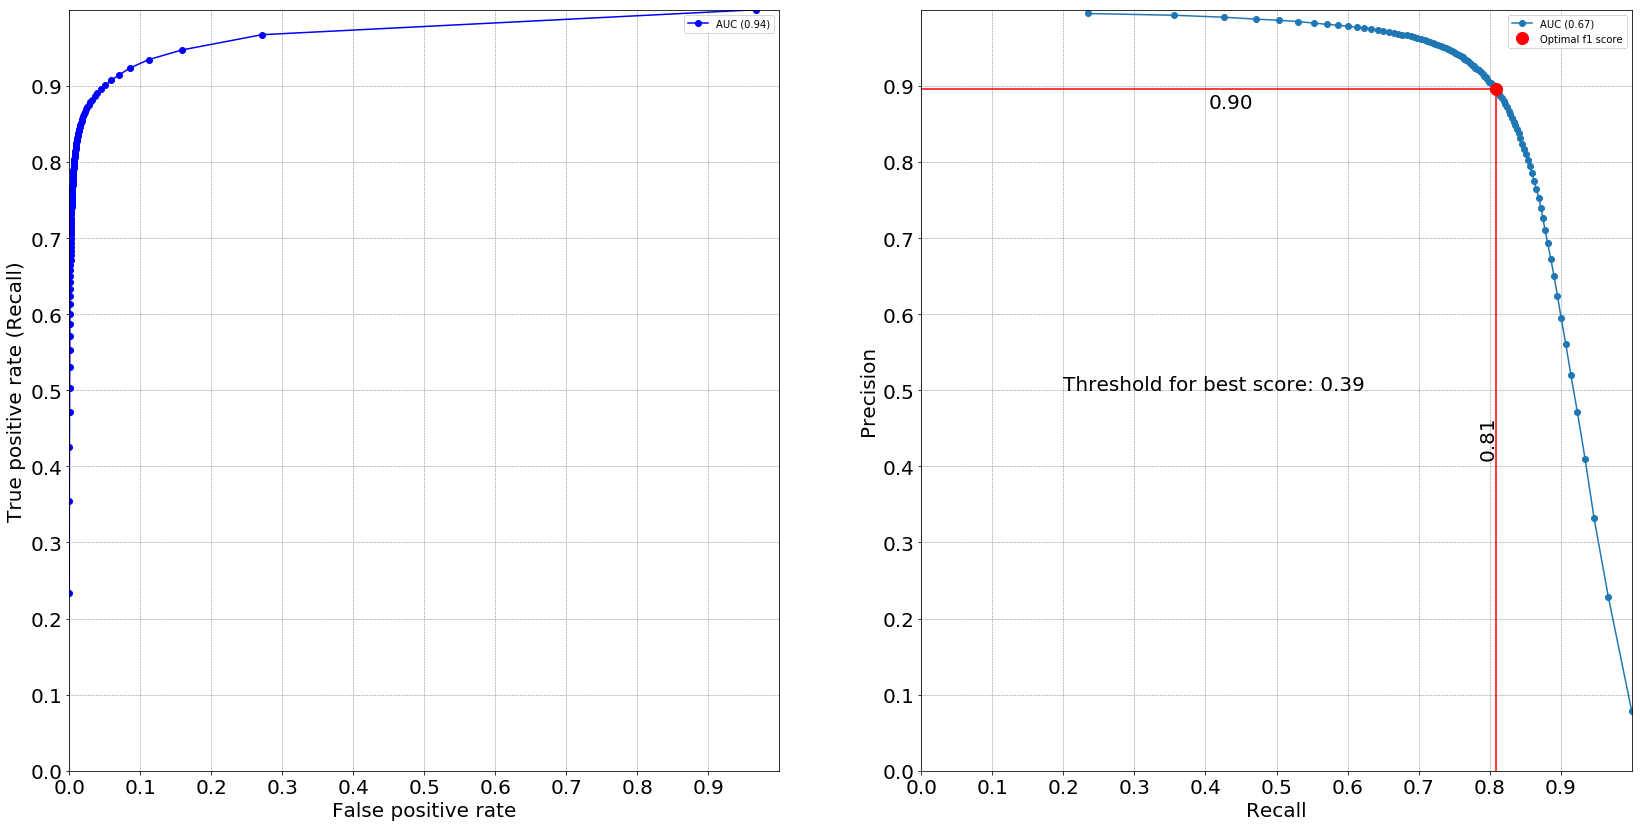

In [22]:
metrics.make_roc_pr_plot(Y_dev, Y_hat, X_dev)

## Getting optimal threshols for sentence accuracy based on F1 score

In [23]:
best_sentence_accuracy, threshold = metrics.get_best_sentence_accuracy(Y_dev, Y_hat)
print('Probability threshold', threshold)
print('Sentence accuracy', best_sentence_accuracy)

Probability threshold [ 0.39]
Sentence accuracy [ 0.69834417]


## Look at how sentence accuracy changes with sentence length
I'm sure that the code below can be written in a more elegant way. Possibly using a Pandas dataframe and grouping, but this will have to do for now.

In [260]:
np.ceil(1/10)

1.0

In [338]:
group_size = 2
lengths = np.arange(group_size, MAX_CHUNKS + group_size, group_size)
n_in_len = np.zeros((1,len(lengths)))
accs_in_len = np.zeros((1,len(lengths)))
positives_in_len = np.zeros((1,len(lengths)))
negatives_in_len = np.zeros((1,len(lengths)))
tp_in_len = np.zeros((1,len(lengths)))
fp_in_len = np.zeros((1,len(lengths)))
fn_in_len = np.zeros((1,len(lengths)))

In [339]:
def get_tp_fp_fn(y, y_hat, x, threshold):
    positives_in_example = np.sum(y)
    negatives_in_example = np.sum(x>0) - positives_in_example
    idx_true = np.where(y==1)[0]
    idx_pred = np.where(y_hat>threshold)[0]
    tp, fp, fn = 0, 0, 0
    for true_idx in idx_true:
        if true_idx in idx_pred:
            tp += 1
        else:
            fn += 1
    for pred_idx in idx_pred:
        if (pred_idx not in idx_true) and (pred_idx <= negatives_in_example):
            fp += 1
    return positives_in_example, negatives_in_example, tp, fn, fp

In [346]:
for y_dev, y_hat, x_dev in zip(Y_dev, Y_hat, X_dev):
    pred_is_accurate = np.array_equal(y_dev, y_hat>threshold[0])
    sen_len = np.sum(np.sum(x_dev>0))
    group = int(np.ceil((sen_len)/group_size))-1
    n_in_len[0,group] = n_in_len[0,group] + 1
    if pred_is_accurate:
        accs_in_len[0, group] = accs_in_len[0, group] + 1 
    
    positives_in_example, negatives_in_example, tp, fn, fp = get_tp_fp_fn(y_dev, y_hat, x_dev, threshold[0])
    
    positives_in_len[0, group] = positives_in_len[0, group] + positives_in_example
    negatives_in_len[0, group] = negatives_in_len[0, group] + negatives_in_example
    tp_in_len[0, group] = tp_in_len[0, group] + tp
    fp_in_len[0, group] = fp_in_len[0, group] + fp
    fn_in_len[0, group] = fn_in_len[0, group] + fn

In [351]:
accuracy_in_len = accs_in_len[0]/n_in_len[0]
precision_in_len = np.divide(tp_in_len[0], tp_in_len[0]+fp_in_len[0])
recall_in_len = np.divide(tp_in_len[0], positives_in_len[0])

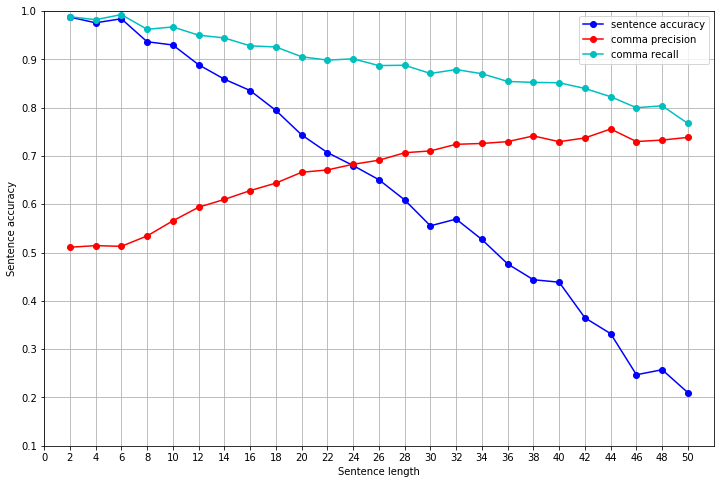

In [355]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lengths, accuracy_in_len, 'ob-', label='sentence accuracy');
ax.plot(lengths, precision_in_len, 'or-', label='comma precision');
ax.plot(lengths, recall_in_len, 'oc-', label='comma recall');
ax.set(xlabel='Sentence length', ylabel='Sentence accuracy');
ax.set_ylim([0.1, 1])
ax.set_xlim([0, MAX_CHUNKS + group_size])
ax.set_xticks(np.arange(0, MAX_CHUNKS + group_size, group_size))
ax.set_yticks(np.arange(0.1 ,1.1, 0.1))
ax.grid()
ax.legend();

# Manuel error analysis

In [201]:
def manual_error_analysis(eu_data, idx, Y, Y_hat, threshold=0.5):
    if idx is None:
        agree = np.array([np.array_equal(y, y_hat>threshold) for y, y_hat in zip(Y_dev, Y_hat)])
        idx_of_wrong = np.where(agree==0)[0]
        idx = idx_of_wrong[np.random.randint(len(idx_of_wrong))]
    y = Y[idx]
    y_hat = Y_hat[idx]
    words = eu_data[idx].features
    idx_true = np.where(y==1)[0]
    idx_pred = np.where(y_hat>threshold)[0]
    for true_idx in idx_true:
        if true_idx in idx_pred:
            words[true_idx] = words[true_idx]+', [TP]'
        else:
            words[true_idx] = words[true_idx]+', [FN]'
    for pred_idx in idx_pred:
        if pred_idx not in idx_true:
            words[pred_idx] = words[pred_idx]+' [FP]'
    print(' '.join(words))
    print('')
    print('Sentence with index:', idx)

In [204]:
manual_error_analysis(eu_data_dev, None, Y_dev, Y_hat, threshold=threshold[0])

I artikel NUMBER, [FN] stk NUMBER, [TP] tales der om et menneskeligt gen, [TP] der er isoleret, [TP] men det skal fastslås, [TP] at også det isolerede menneskelige gen forbliver et gen

Sentence with index: 1984


# Prediction

In [24]:
def apply_commas(sentence, commas):
    assert len(sentence.chunks) == len(commas)
    temp = ""
    for chunk, comma in zip(sentence.chunks, commas):
        if comma == chunk.comma:
            temp += chunk.name + chunk.trailing_whitespace
            continue
        
        if comma:
            temp += chunk.name + "," + chunk.trailing_whitespace
        else:
            temp += chunk.name[:-1] + chunk.trailing_whitespace
    return temp

In [46]:
#example = 'Dette er en sætning som der burde indholde et komma .'
#example = """det bliver bedre hvis du øver dig lidt først"""
#example = "jeg spiser kage hvad spiser du?"
#example = "ved du hvad tid toget kører?"
example = "Og til gengæld sker der det og jeg gentager at den samlede landbrugsstøtte vil stige med hele 8% indtil 2013 uden at medregne optagelsen af Bulgarien og Rumænien der er planlagt til 2007."
#example = "Ja det var hyggeligt."
example = parser.parse(example)
embedded = embed_sentence(example, vocab)
embedded = sequence.pad_sequences([embedded], maxlen=MAX_CHUNKS)
yhat = model.predict_proba(embedded)
y_hat_commas = yhat[0][:len(example.chunks)] >= threshold[0]
print("origbinal:", example)
print("fixed:", apply_commas(example, y_hat_commas))

unknown_word_idx = np.where(embedded[0]==len(vocab)+1)[0]
print('words embedded to UNKNOWN:', len(unknown_word_idx))
for idx in unknown_word_idx:
    print(example.features[idx])

1/1 [==============================] - 0s
origbinal: Og til gengæld sker der det og jeg gentager at den samlede landbrugsstøtte vil stige med hele 8% indtil 2013 uden at medregne optagelsen af Bulgarien og Rumænien der er planlagt til 2007.
fixed: Og til gengæld sker der det, og jeg gentager, at den samlede landbrugsstøtte vil stige med hele 8% indtil 2013 uden at medregne optagelsen af Bulgarien og Rumænien, der er planlagt til 2007.
words embedded to UNKNOWN: 2
8%
medregne
